In [ ]:
# Extracts tile, Canny Edge Detection, Watershed Algorithm, Marker Labelling, ROI Extraction,  Feature Extraction
# Code written by A Siddharth Reddy

In [ ]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 20.2 MB/s eta 0:00:00


In [ ]:
import rasterio
from rasterio.windows import Window
import cv2
import numpy as np
from IPython.display import Image, display
import matplotlib.pyplot as plt
import os
import pandas as pd
from skimage.feature import graycomatrix, graycoprops

In [ ]:
# Function to calculate local homogeneity
def calculate_local_homogeneity(gray_image, mask):
    glcm = graycomatrix(gray_image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    homogeneity = graycoprops(glcm, 'homogeneity')
    return homogeneity[0, 0]

# Function to calculate global homogeneity
def calculate_global_homogeneity(roi_gray):
    glcm = graycomatrix(roi_gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    homogeneity = graycoprops(glcm, 'homogeneity')
    return homogeneity[0, 0]

In [ ]:
# Function to create synthetic images based on features
def create_synthetic_image(features, image_size=(100, 100)):
    img = np.zeros(image_size, dtype=np.uint8)
    center = (image_size[1] // 2, image_size[0] // 2)
    major_axis = int(features['Major Axis'])
    minor_axis = int(features['Minor Axis'])
    angle = 0

    # Drawing the ellipse based on major and minor axis
    cv2.ellipse(img, center, (major_axis // 2, minor_axis // 2), angle, 0, 360, 255, -1)

    # Adding more geometric shapes based on other features
    equivalent_radius = int(features['Equivalent Diameter'] / 2)
    cv2.circle(img, center, equivalent_radius, 128, -1)  # Gray circle is for equivalent diameter

    return img

In [ ]:
# Defining the imshow function
def imshow(img, ax=None):
    if ax is None:
        ret, encoded = cv2.imencode(".jpg", img)
        display(Image(encoded))
    else:
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')


In [ ]:
# Directories for saving ROIs
if not os.path.exists('All_ROIs'):
    os.makedirs('All_ROIs')
if not os.path.exists('Extracted_ROIs'):
    os.makedirs('Extracted_ROIs')


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


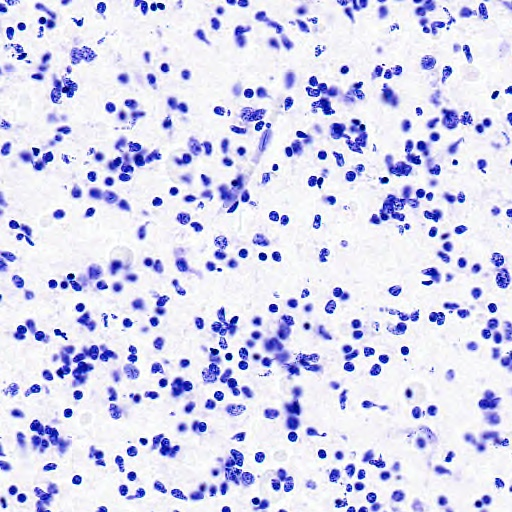

In [ ]:
# Path to the JP2 image
jp2_image_path = '/content/drive/MyDrive/B_118_FB10-SL_280-ST_NISL-SE_838_compressed.jp2'

# Opening the image using rasterio
with rasterio.open(jp2_image_path) as src:
    # Defining the tile to extract
    window = Window(col_off=67000, row_off=67000, width=512, height=512)

    # Reading the tile from the image
    img = src.read(window=window)

    # Converting the tile to a format suitable for displaying with OpenCV
    img = img.transpose(1, 2, 0)  # Converted from (bands, rows, cols) to (rows, cols, bands)

    # Rasterio reads the image in RGB order, thats why we need to convert it to BGR for OpenCV
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# To display the extracted tile
imshow(img)


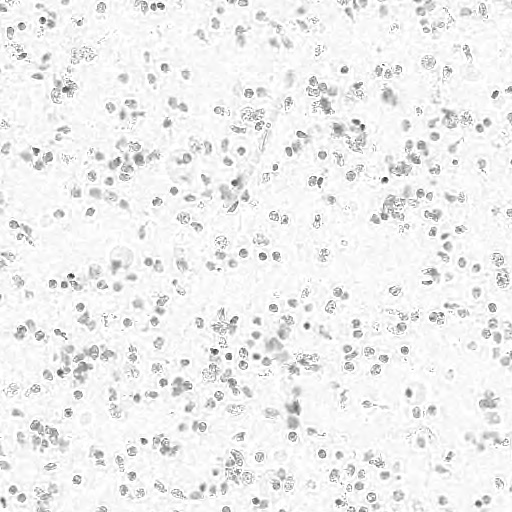

In [ ]:
# Extracting the blue channel
blue_channel = img[:, :, 0]
imshow(blue_channel)

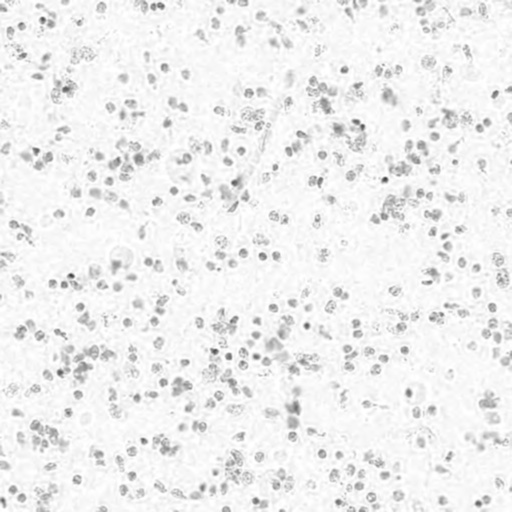

In [ ]:
# Applying Gaussian Blur to the blue channel
blurred_img = cv2.GaussianBlur(blue_channel, (3, 3), 0)
imshow(blurred_img)

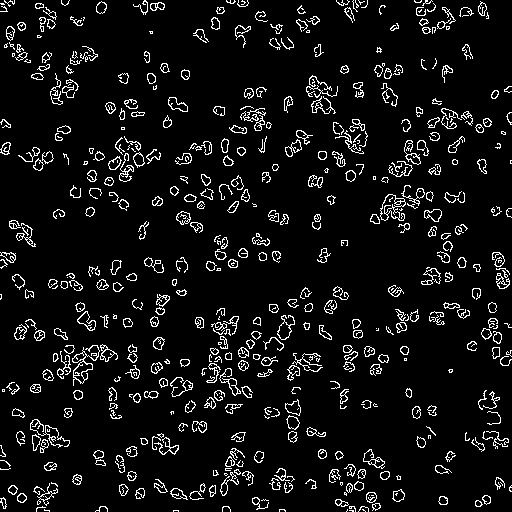

In [ ]:
# Canny Edge Detection
edges = cv2.Canny(blurred_img, 100, 200)
imshow(edges)

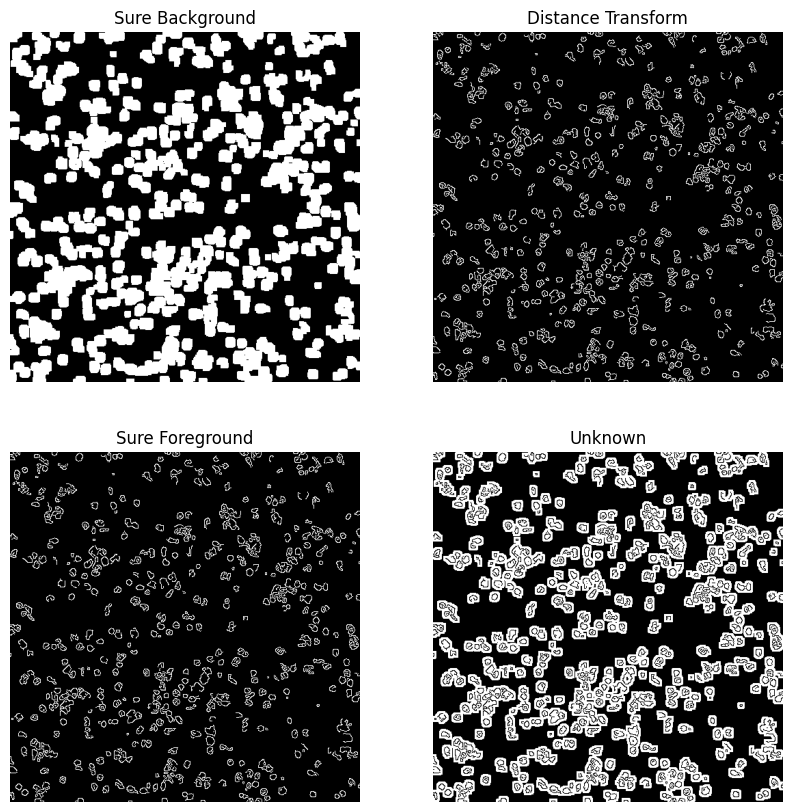

In [ ]:
# Creating subplots with 2 rows and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Sure background area
sure_bg = cv2.dilate(edges, None, iterations=3)
imshow(sure_bg, axes[0, 0])
axes[0, 0].set_title('Sure Background')

# Distance transform
dist = cv2.distanceTransform(edges, cv2.DIST_L2, 5)
imshow(dist, axes[0, 1])
axes[0, 1].set_title('Distance Transform')

# Foreground area
ret, sure_fg = cv2.threshold(dist, 0.3 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)
imshow(sure_fg, axes[1, 0])
axes[1, 0].set_title('Sure Foreground')

# Unknown area
unknown = cv2.subtract(sure_bg, sure_fg)
imshow(unknown, axes[1, 1])
axes[1, 1].set_title('Unknown')

plt.show()

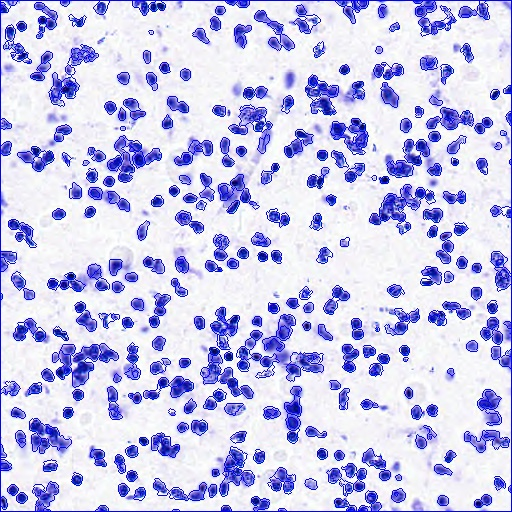

In [ ]:
# Marker labeling
ret, markers = cv2.connectedComponents(sure_fg)

# Adding 1 to all labels so that the background is not 0, but 1
markers = markers + 1

# Marking the region of unknown with zero
markers[unknown == 255] = 0

# Applying the watershed algorithm
markers = cv2.watershed(img, markers)
img[markers == -1] = [255, 0, 0]

# To show the image with markers
imshow(img)


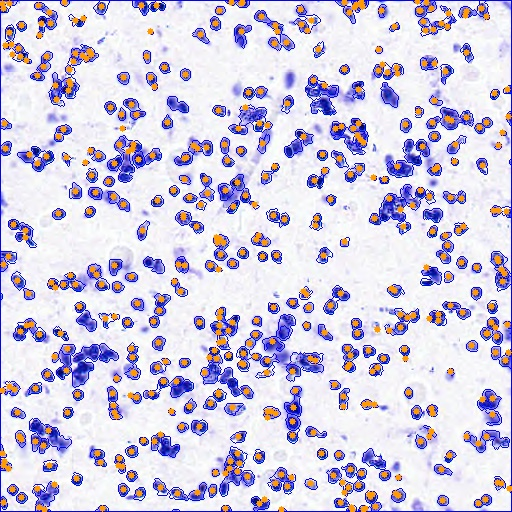

In [ ]:
# Creating a list to store the contours
labels = np.unique(markers)
cells = []

for label in labels[2:]:
    # To create a binary image where the area of the label is in the foreground and the rest is background
    target = np.where(markers == label, 255, 0).astype(np.uint8)

    # Performing contour extraction
    contours, hierarchy = cv2.findContours(target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cells.append(contours[0])

# To draw the centroids on the original image without any other markings
centroids_img = img.copy()

# Initializing a list to store areas of all ROIs
cell_areas = []

# Initializing a list to store features of all ROIs
features_list = []

for label in labels[2:]:  # Here we are skipping background and boundary markers
    # Creating a binary image where the area of the label is in the foreground and the rest is background
    target = np.where(markers == label, 255, 0).astype(np.uint8)

    # Contour extraction
    contours, hierarchy = cv2.findContours(target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # To calculate bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)

        # Getting ROI from original image and resize to dynamically calculated size
        roi = img[y:y+h, x:x+w]

        # Saving ROI to file without any markings
        roi_file = f'All_ROIs/cell_roi_{label}.jpg'
        cv2.imwrite(roi_file, roi)

        # To calculat area of the contour (cell)
        area = cv2.contourArea(contour)
        cell_areas.append(area)

        # If area is below or equal to the threshold, we save ROI to 'Extracted_ROIs'
        if area <= 150:
            extracted_roi_file = f'Extracted_ROIs/cell_roi_{label}.jpg'
            cv2.imwrite(extracted_roi_file, roi)

            # To calculate shape descriptors and contrast
            aspect_ratio = float(w) / h
            rect_area = w * h
            extent = float(area) / rect_area
            hull = cv2.convexHull(contour)
            hull_area = cv2.contourArea(hull)
            # To handle potential zero hull area
            # We skip this contour if the hull area is zero
            if hull_area == 0:
                continue

            solidity = float(area) / hull_area

            mask = np.zeros(blue_channel.shape, np.uint8)
            cv2.drawContours(mask, [contour], -1, 255, -1)
            pixel_values = blue_channel[mask == 255]
            contrast = np.var(pixel_values)**2
            local_homogeneity = calculate_local_homogeneity(blue_channel, mask)
            # To convert the ROI to grayscale for global homogeneity calculation
            roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            global_homogeneity = calculate_global_homogeneity(roi_gray)

            # To calculate perimeter
            perimeter = cv2.arcLength(contour, True)

            # To calculate minor axis using the bounding rectangle
            minor_axis = min(w, h)

            # To calculate major axis using the bounding rectangle
            major_axis = max(w, h)

            # To calculate equivalent diameter
            equivalent_diameter = np.sqrt(4 * area / np.pi)

            # To calculate circularity
            circularity = 4 * np.pi * (area / (perimeter ** 2)) if perimeter != 0 else 0

            # To calculate convexity
            convexity = cv2.isContourConvex(contour)

            # To calculate centroid using moments
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                # To draw centroids on the centroids image
                cv2.circle(centroids_img, (cx, cy), 3, (0, 155, 255), -1)  # Draw centroid as a yellow dot

            # Appending all features to the list
            features_list.append([ label, area, aspect_ratio, extent, solidity, contrast, local_homogeneity, global_homogeneity, perimeter, minor_axis, major_axis, equivalent_diameter, circularity, convexity])

# Creating a DataFrame from the features list
features_df = pd.DataFrame(features_list, columns=[
    "Label", "Area", "Aspect Ratio", "Extent", "Solidity", "Contrast",
    "Local Homogeneity", "Global Homogeneity", "Perimeter", "Minor Axis",
    "Major Axis", "Equivalent Diameter", "Circularity", "Convexity"
])

# Saving the DataFrame to a CSV file
features_df.to_csv("cell_features_withblue.csv", index=False)

# Displaying the image with only centroids
imshow(centroids_img)

plt.show()